In [1]:
# Library Imports 
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import my_functions as mf
from scipy.optimize import curve_fit
from scipy.fftpack import fft, ifft, fftfreq
from scipy.special import voigt_profile
from scipy.signal import convolve
importlib.reload(mf)



<module 'my_functions' from '/Users/fergusayton/Documents/My Library/fayt3249/2024/Honours Thesis/sample_coupling_analysis/my_functions.py'>

[-4.21300000e-06  3.48769400e-03  6.99827600e-03  1.04906800e-02
  1.39893630e-02  1.74861770e-02  2.09938910e-02  2.44877290e-02
  2.79977330e-02  3.14869090e-02  3.50001280e-02  3.84868160e-02
  4.19959030e-02  4.54851400e-02  4.89785360e-02  5.24959890e-02
  5.59946240e-02  5.94897870e-02  6.29841140e-02  6.64953890e-02
  6.99843200e-02  7.34969750e-02  7.69963510e-02  8.04894270e-02
  8.39984730e-02  8.74997520e-02  7.50120800e-02  7.85032200e-02
  8.19987360e-02  8.54973710e-02  8.89838620e-02  9.24871730e-02
  9.29850500e-02  9.59936980e-02  9.89880070e-02  1.01988236e-01
  1.04992399e-01]
(37,)
[3.9512339  3.9512339  3.9512339  3.9511334  3.9511334  3.95118365
 3.95118365 3.95118365 3.95108315 3.95128415 3.9512339  3.95118365
 3.95108315 3.9511334  3.9512339  3.95118365 3.9511334  3.95108315
 3.9511334  3.9511334  3.9512339  3.9512339  3.9511334  3.95118365
 3.9512339  3.95118365 3.9511334  3.9511334  3.95118365 3.9511334
 3.9511334  3.95118365 3.95118365 3.95118365 3.95108315 3

/var/folders/zj/k61bftd91r1cdpjh8_mkq7nm0000gn/T/ipykernel_32083/1320825229.py:55: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(aligned_frequencies, magnetic_fields, s21_magnitudes, shading='auto', cmap='viridis')


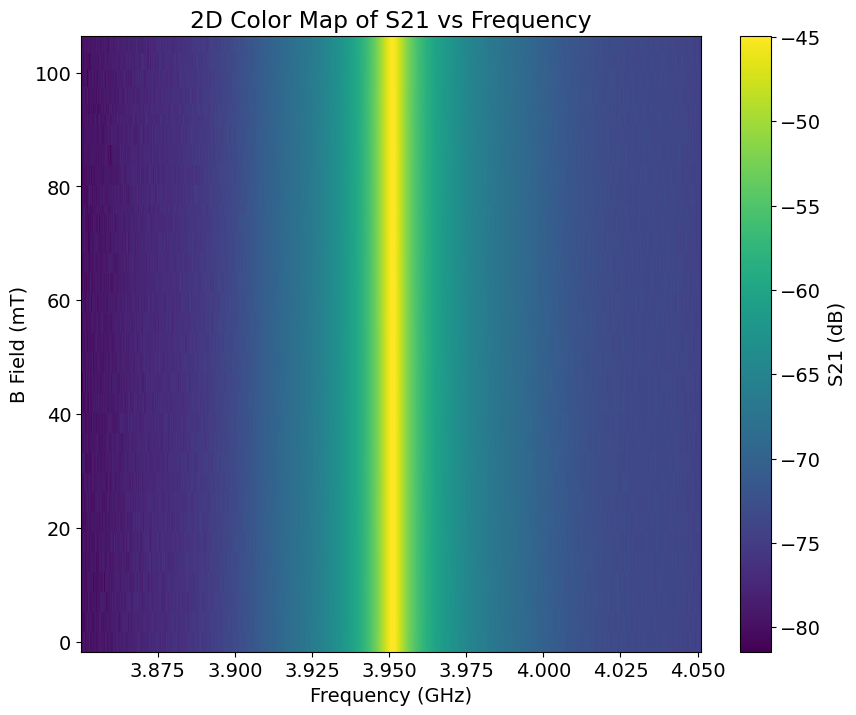

/var/folders/zj/k61bftd91r1cdpjh8_mkq7nm0000gn/T/ipykernel_32083/1320825229.py:71: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(zoomed_frequencies, magnetic_fields, zoomed_s21_magnitudes, shading='auto', cmap='viridis')


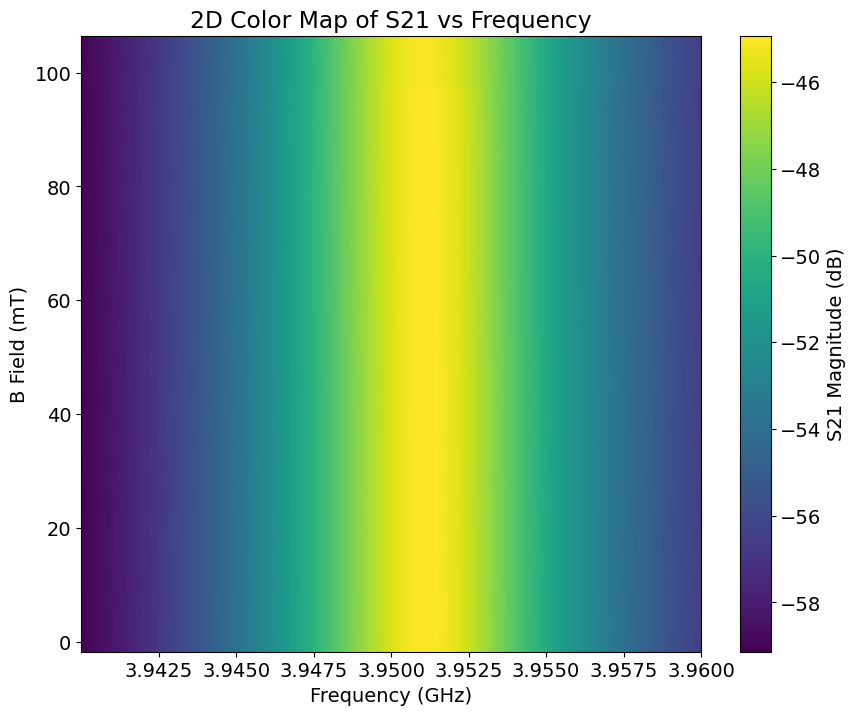

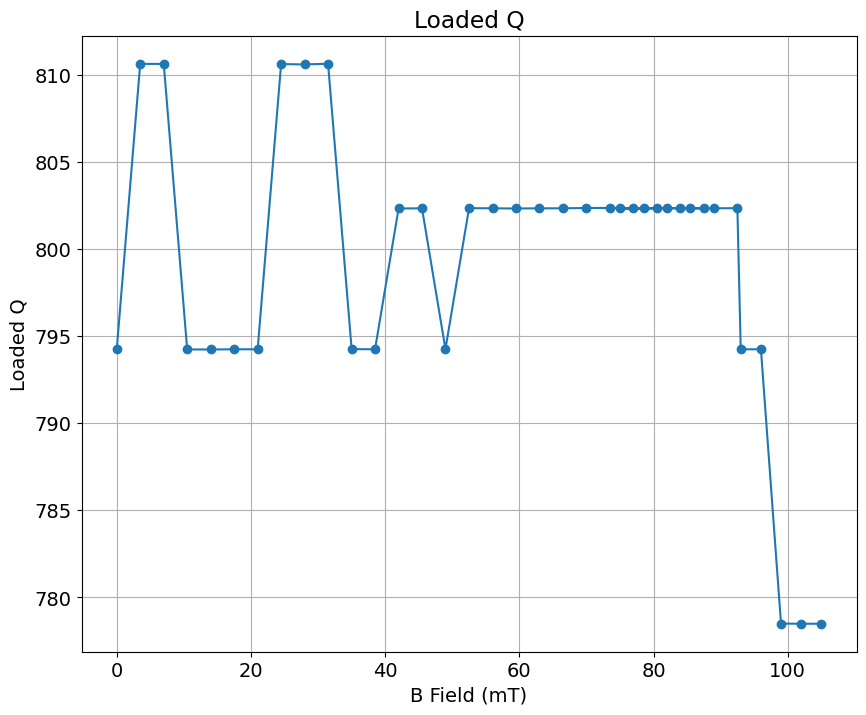

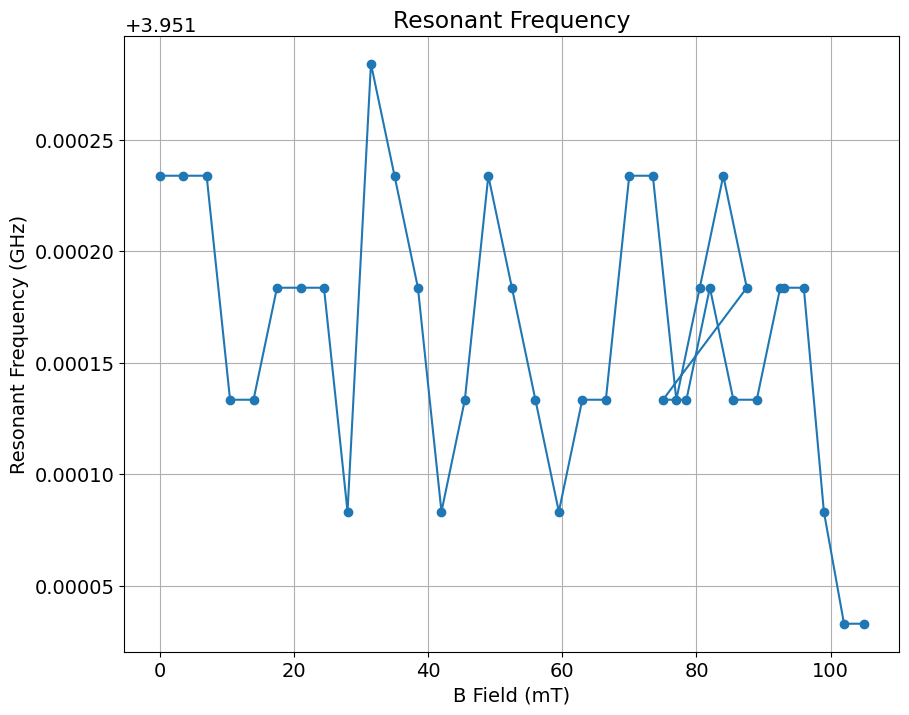

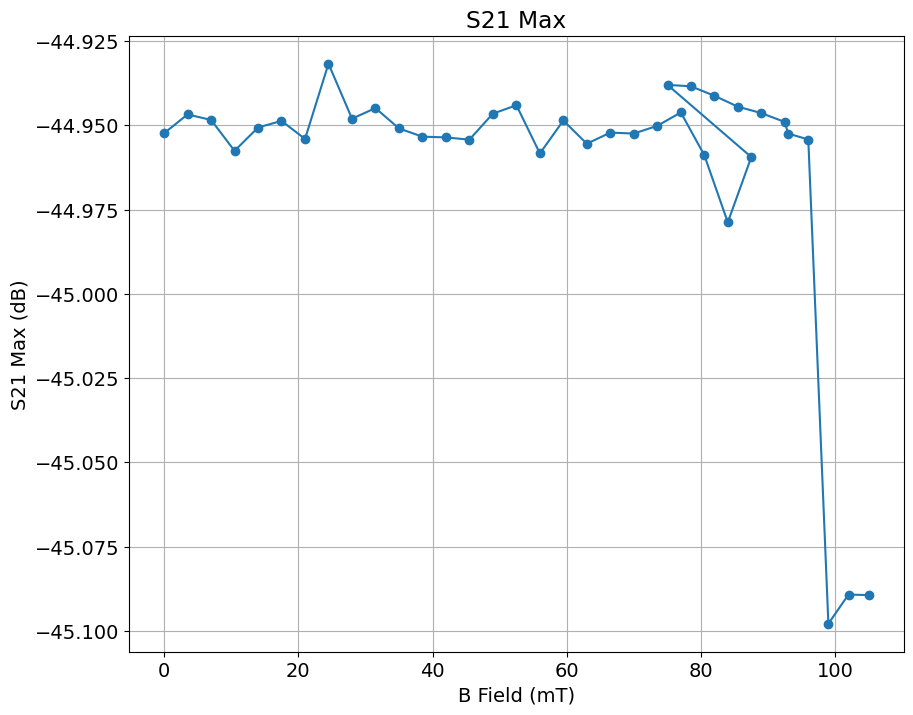

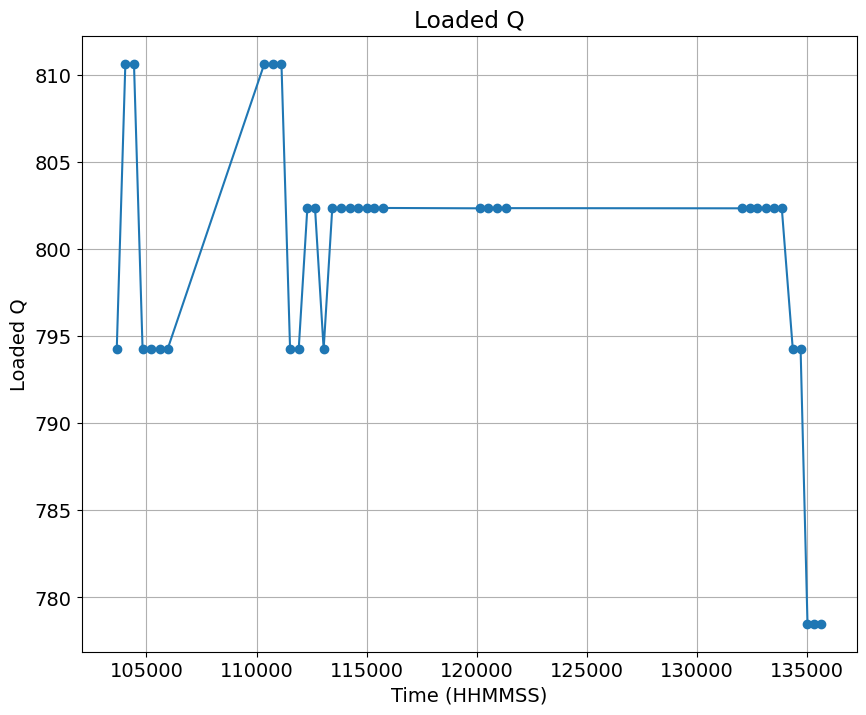

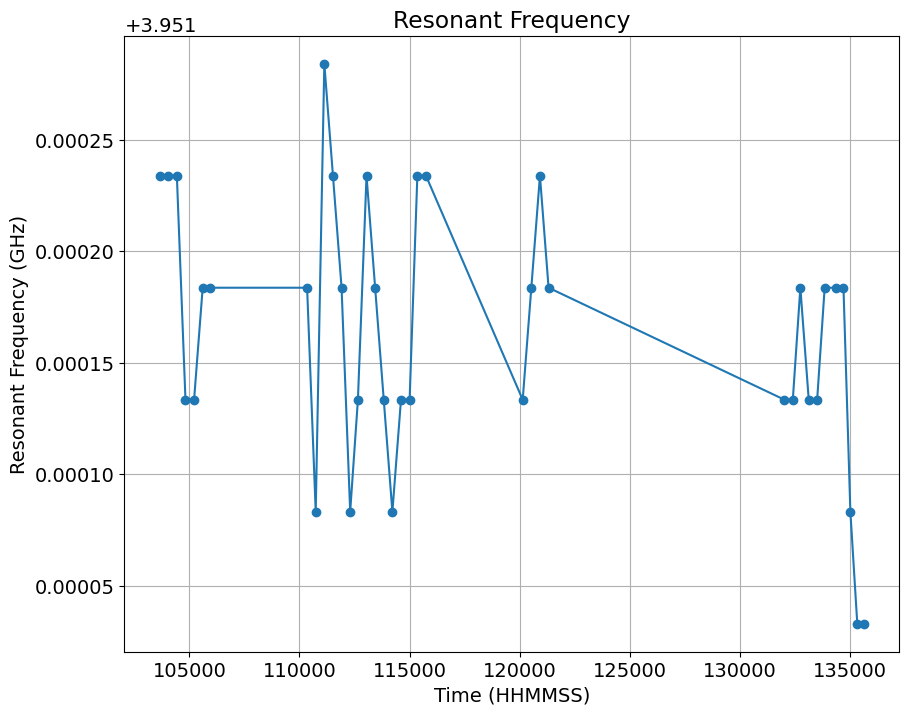

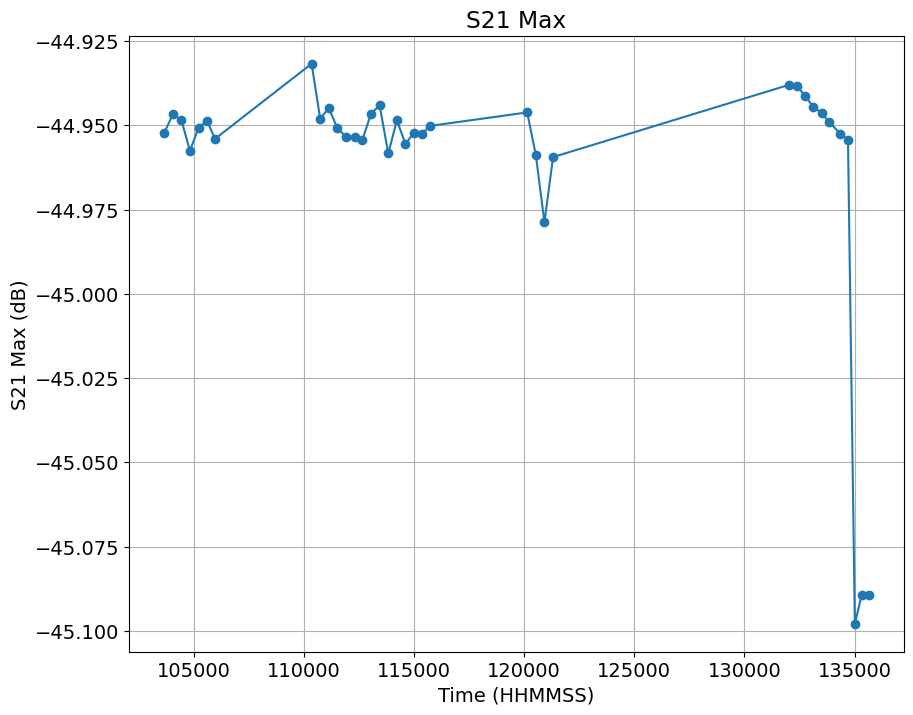

In [29]:

path = "data_vna/data_14_01_magnet_ramp/"
data_files =  sorted(glob.glob(path +"*"))

aligned_frequencies = None
s21_magnitudes = []
spectra_times = []
magnetic_fields = []
loaded_q =[]
resonant_freq =[]
s21_max = []
 
# Process each file
for file in data_files:
    data = mf.read_VNA_data(file)
    time_str = file.split('_')[-1]
    time_str = int(time_str.replace("-", ""))
    spectra_times.append(time_str)

    features = mf.calculate_S21_features(data, [3.86, 4.06], to_print=False)
    loaded_q.append(features.get("Q_loaded"))
    resonant_freq.append(features.get("f_r"))
    s21_max.append(features.get("S_21_mag_at_f_r"))

    # Use the first file's frequencies as the reference grid
    if aligned_frequencies is None:
        aligned_frequencies = data["Frequency (GHz)"].values
    
    # Interpolate S21 data onto the reference frequency grid
    interp_s21 = np.interp(aligned_frequencies, data["Frequency (GHz)"], data["S21 (dB)"])
    s21_magnitudes.append(interp_s21)

    # Interpolate S21 data onto the reference frequency grid
    interp_B = np.interp(aligned_frequencies, data["Frequency (GHz)"], data["Magnetic Field (T)"])
    magnetic_fields.append(interp_B)


# Convert to 2D array for plotting
s21_magnitudes = np.array(s21_magnitudes)
magnetic_fields = np.array(magnetic_fields)
resonant_freq = np.array(resonant_freq)
s21_magnitudes = np.array(s21_magnitudes)
loaded_q = np.array(loaded_q)

assert np.all(magnetic_fields == magnetic_fields[:, [0]]), "Not all values in each row are identical!"
magnetic_fields = magnetic_fields[:,0]
print(magnetic_fields)
print(np.shape(magnetic_fields))
magnetic_fields = magnetic_fields*1e3
resonant_freq = resonant_freq.squeeze()
print(resonant_freq)
print(np.shape(resonant_freq))

# Create a 2D color map plot
plt.figure(figsize=(10, 8))
plt.pcolormesh(aligned_frequencies, magnetic_fields, s21_magnitudes, shading='auto', cmap='viridis')
plt.colorbar(label="S21 (dB)")
plt.xlabel("Frequency (GHz)")
plt.ylabel("B Field (mT)")
plt.title("2D Color Map of S21 vs Frequency")
plt.show()


lower_bound_freq= 3.94
upper_bound_freq = 3.96
zoom_mask = (aligned_frequencies >= lower_bound_freq) & (aligned_frequencies <= upper_bound_freq)
zoomed_frequencies = aligned_frequencies[zoom_mask]
zoomed_s21_magnitudes = s21_magnitudes[:, zoom_mask]
#zoomed_magnetic_fields = magnetic_fields[:, zoom_mask]

plt.figure(figsize=(10, 8))
plt.pcolormesh(zoomed_frequencies, magnetic_fields, zoomed_s21_magnitudes, shading='auto', cmap='viridis')
plt.colorbar(label="S21 Magnitude (dB)")
plt.xlabel("Frequency (GHz)")
plt.ylabel("B Field (mT)")
plt.title("2D Color Map of S21 vs Frequency")
plt.show()

# First Plot: Loaded Q
fig1 = plt.figure(figsize=(10, 8))
plt.rc("font", size=14)
plt.plot(magnetic_fields, loaded_q, label="Loaded Q, f1",ß marker="o")
plt.xlabel("B Field (mT)")
plt.ylabel("Loaded Q")
plt.title("Loaded Q")
plt.grid()
plt.show()

# Second Plot: Resonant Frequency
fig2 = plt.figure(figsize=(10, 8))
plt.rc("font", size=14)
plt.plot(magnetic_fields, resonant_freq, label="Resonant Frequency", marker="o")
plt.xlabel("B Field (mT)")
plt.ylabel("Resonant Frequency (GHz)")
plt.title("Resonant Frequency")
plt.grid()
plt.show()

# Third Plot: S21 Max
fig3 = plt.figure(figsize=(10, 8))
plt.rc("font", size=14)
plt.plot(magnetic_fields, s21_max, label="S21 Max", marker="o")
plt.xlabel("B Field (mT)")
plt.ylabel("S21 Max (dB)")
plt.title("S21 Max")
plt.grid()
plt.show()

# First Plot: Loaded Q
fig1 = plt.figure(figsize=(10, 8))
plt.rc("font", size=14)
plt.plot(spectra_times, loaded_q, label="Loaded Q, f1", marker="o")
plt.xlabel("Time (HHMMSS)")
plt.ylabel("Loaded Q")
plt.title("Loaded Q")
plt.grid()
plt.show()

# Second Plot: Resonant Frequency
fig2 = plt.figure(figsize=(10, 8))
plt.rc("font", size=14)
plt.plot(spectra_times, resonant_freq, label="Resonant Frequency", marker="o")
plt.xlabel("Time (HHMMSS)")
plt.ylabel("Resonant Frequency (GHz)")
plt.title("Resonant Frequency")
plt.grid()
plt.show()

# Third Plot: S21 Max
fig3 = plt.figure(figsize=(10, 8))
plt.rc("font", size=14)
plt.plot(spectra_times, s21_max, label="S21 Max", marker="o")
plt.xlabel("Time (HHMMSS)")
plt.ylabel("S21 Max (dB)")
plt.title("S21 Max")
plt.grid()
plt.show()
